In [2]:
import sys
sys.path.insert(0, '../../')
sys.path.insert(0, '../../aspforaba/')
sys.path.insert(0, '../../GradualABA/')
sys.path.insert(0, '../../ArgCausalDisco/')
sys.path.insert(0, '../../notears/')

import argparse
import numpy as np
import pandas as pd
import time
from functools import partial
from pathlib import Path
from tqdm import tqdm

from ArgCausalDisco.utils.helpers import random_stability
from GradualABA.semantics.modular.LinearInfluence import LinearInfluence
from GradualABA.semantics.modular.SetMinAggregation import SetMinAggregation
from logger import logger
from src.abapc import get_cg_and_facts, score_model_original
from src.gradual.run import reset_weights, run_model, set_weights_according_to_facts
from src.gradual.scalable.bsaf_builder_v2 import BSAFBuilderV2
from src.gradual.search_best_model import limited_depth_search_best_model
from src.gradual.semantic_modules.TopDiffAggregation import TopDiffAggregation
from src.utils.configure_r import configure_r
from src.utils.bn_utils import get_dataset
from src.utils.metrics import get_metrics
from src.utils.resource_utils import MemoryUsageExceededException
from src.utils.utils import check_arrows_dag, get_matrix_from_arrow_set, parse_arrow
from src.constants import DAG_NODES_MAP, DAG_EDGES_MAP




ALPHA = 0.01
INDEP_TEST = 'fisherz'

SAMPLE_SIZE = 5000
SEED = 2024


/opt/homebrew/Caskroom/miniconda/base/envs/aba-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
INFO:root:You are using ``pytorch`` as the backend.


In [3]:
dataset='cancer'

In [4]:
n_nodes = DAG_NODES_MAP[dataset]
logger.info(f"Running experiment for dataset: {dataset}")

random_stability(SEED)
seeds_list = np.random.randint(0, 10000, (1,)).tolist()

# create bsaf
start_bsaf_creation = time.time()
try:
    bsaf_builder = BSAFBuilderV2(
        n_nodes=n_nodes,
        include_collider_tree_arguments=True,
        neighbourhood_n_nodes=n_nodes,
        max_conditioning_set_size=n_nodes-2)  # everything is maximal for given n_nodes, full scale
    bsaf = bsaf_builder.create_bsaf()
    assumptions_dict = bsaf_builder.name_to_assumption
except MemoryUsageExceededException as e:
    logger.error(
        f"Memory usage exceeded while creating BSAF for {dataset}")
    raise e
elapsed_bsaf_creation = time.time() - start_bsaf_creation

for seed in tqdm(seeds_list, desc=f"Seeds for {dataset}"):
    X_s, B_true = get_dataset(dataset_name=dataset,
                                seed=seed,
                                sample_size=SAMPLE_SIZE
                                )
    random_stability(seed)
    start = time.time()
    cg, facts = get_cg_and_facts(X_s, alpha=ALPHA, indep_test=INDEP_TEST)
    facts = sorted(facts, key=lambda x: x.score, reverse=True)  # sort by score
    elapsed_fact_sourcing = time.time() - start

    # run gradual aba to get the strengths
    start_model_solution = time.time()
    reset_weights(assumptions_dict)
    set_weights_according_to_facts(assumptions_dict, facts)
    output = run_model(
        n_nodes=n_nodes,
        bsaf=bsaf,
        model_name=None,
        set_aggregation=SetMinAggregation(),
        aggregation=TopDiffAggregation(),
        influence=LinearInfluence(conservativeness=1),
        conservativeness=1,
        iterations=25,
    )
    elapsed_model_solution = time.time() - start_model_solution
    is_converged = all(output.has_converged_map.values())

    score_original_prefilled = partial(score_model_original,
                                        n_nodes=n_nodes,
                                        cg=cg,
                                        alpha=ALPHA,
                                        return_only_I=True)

    sorted_arrows = sorted([(strength, arrow) for arrow, strength in output.arrow_strengths.items()],
                        reverse=True)
    sorted_arrows = [parse_arrow(arrow) for _, arrow in sorted_arrows]

    start_orig_ranking = time.time()
    original_ranking_I, best_model_original_ranking = limited_depth_search_best_model(
        steps_ahead=10,
        sorted_arrows=sorted_arrows,
        is_dag=check_arrows_dag,
        get_score=score_original_prefilled
    )
    elapsed_orig_ranking = time.time() - start_orig_ranking


[2025-08-26 13:58:34] INFO - app - Running experiment for dataset: cancer


INFO:app:Running experiment for dataset: cancer
Generating for node: Dyspnoea: 100%|██████████| 5/5 [00:00<00:00, 576.30it/s]
INFO:root:Data shape: (5000, 5)
INFO:root:Number of true edges: 4
INFO:root:True BN edges: [('Pollution', 'Cancer'), ('Smoker', 'Cancer'), ('Cancer', 'Xray'), ('Cancer', 'Dyspnoea')]
INFO:root:DAG? True
INFO:root:True DAG shape: (5, 5), True DAG edges: 4
INFO:root:           Cancer  Dyspnoea  Pollution  Smoker  Xray
Cancer          0         1          0       0     1
Dyspnoea        0         0          0       0     0
Pollution       1         0          0       0     0
Smoker          1         0          0       0     0
Xray            0         0          0       0     0
INFO:root:   Starting Orientation by Separating Set (Majority)
INFO:root:   Starting propagation by Meek Rules (Meek, 1995)


[2025-08-26 13:58:35] INFO - app - solving BSAF with GradualCausalABA


INFO:app:solving BSAF with GradualCausalABA



Discrete modular, iterations:  25 
-------
Aggregation:  TopAggregation
Influence:  LinearInfluence
Set Aggregation:  SetMinAggregation
-------

iter	active_path_0_1_2_3_4__	 active_path_0_1_2_3_4__1	 active_path_0_1_2_3_4__1_2	 active_path_0_1_2_3_4__1_2_3	 active_path_0_1_2_3_4__1_3	 active_path_0_1_2_3_4__2	 active_path_0_1_2_3_4__2_3	 active_path_0_1_2_3_4__3	 active_path_0_1_2_3__	 active_path_0_1_2_3__1	 active_path_0_1_2_3__1_2	 active_path_0_1_2_3__1_2_4	 active_path_0_1_2_3__1_4	 active_path_0_1_2_3__2	 active_path_0_1_2_3__2_4	 active_path_0_1_2_3__4	 active_path_0_1_2_4_3__	 active_path_0_1_2_4_3__1	 active_path_0_1_2_4_3__1_2	 active_path_0_1_2_4_3__1_2_4	 active_path_0_1_2_4_3__1_4	 active_path_0_1_2_4_3__2	 active_path_0_1_2_4_3__2_4	 active_path_0_1_2_4_3__4	 active_path_0_1_2_4__	 active_path_0_1_2_4__1	 active_path_0_1_2_4__1_2	 active_path_0_1_2_4__1_2_3	 active_path_0_1_2_4__1_3	 active_path_0_1_2_4__2	 active_path_0_1_2_4__2_3	 active_path_0_1_2_4__3	 active_path_0

Seeds for cancer: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

20	0.601	 0.497	 0.249	 0.249	 0.497	 0.5	 0.25	 0.5	 0.601	 0.497	 0.249	 0.249	 0.497	 0.5	 0.5	 0.601	 0.601	 0.497	 0.249	 0.249	 0.497	 0.5	 0.25	 0.5	 0.601	 0.497	 0.249	 0.249	 0.497	 0.5	 0.5	 0.601	 0.601	 0.497	 0.497	 0.497	 0.497	 0.601	 0.601	 0.601	 0.601	 0.497	 0.497	 0.249	 0.249	 0.5	 0.25	 0.5	 0.601	 0.497	 0.249	 0.249	 0.497	 0.5	 0.5	 0.601	 0.601	 0.497	 0.249	 0.249	 0.497	 0.5	 0.25	 0.5	 0.601	 0.497	 0.497	 0.249	 0.249	 0.601	 0.5	 0.5	 0.601	 0.497	 0.497	 0.497	 0.497	 0.601	 0.601	 0.601	 0.601	 0.497	 0.497	 0.249	 0.249	 0.5	 0.25	 0.5	 0.601	 0.497	 0.497	 0.249	 0.249	 0.601	 0.5	 0.5	 0.601	 0.497	 0.497	 0.249	 0.249	 0.5	 0.25	 0.5	 0.601	 0.497	 0.497	 0.249	 0.249	 0.601	 0.5	 0.5	 0.601	 0.497	 0.497	 0.497	 0.497	 0.601	 0.601	 0.601	 0.602	 0.602	 0.602	 0.602	 0.602	 0.602	 0.602	 0.602	 0.601	 0.5	 0.249	 0.249	 0.25	 0.497	 0.497	 0.5	 0.601	 0.5	 0.249	 0.249	 0.5	 0.497	 0.497	 0.601	 0.601	 0.5	 0.249	 0.249	 0.25	 0.497	 0.497	 0.5	 0

Seeds for cancer: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


In [11]:
# plotting evolution of arrow strengths
import matplotlib.pyplot as plt
def plot_strengths_given_asms(ax,
                              graph_data,
                              title="Untitled graph",
                              alpha=0.5,
                              cmap='turbo',
                              linewidth_pt=1,
                              ):
    cmap = plt.get_cmap(cmap)
    for name, seq in graph_data.items():
        xs = [t for (t, _) in seq]
        ys = [v for (_, v) in seq]
        color = cmap(np.random.rand())
        ax.plot(xs, ys, label=name, color=color, alpha=alpha, linewidth=linewidth_pt)

    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Dialectical Strength")
    ax.set_title(title)

    ax.grid()
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    return plt



<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniconda/base/envs/aba-env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

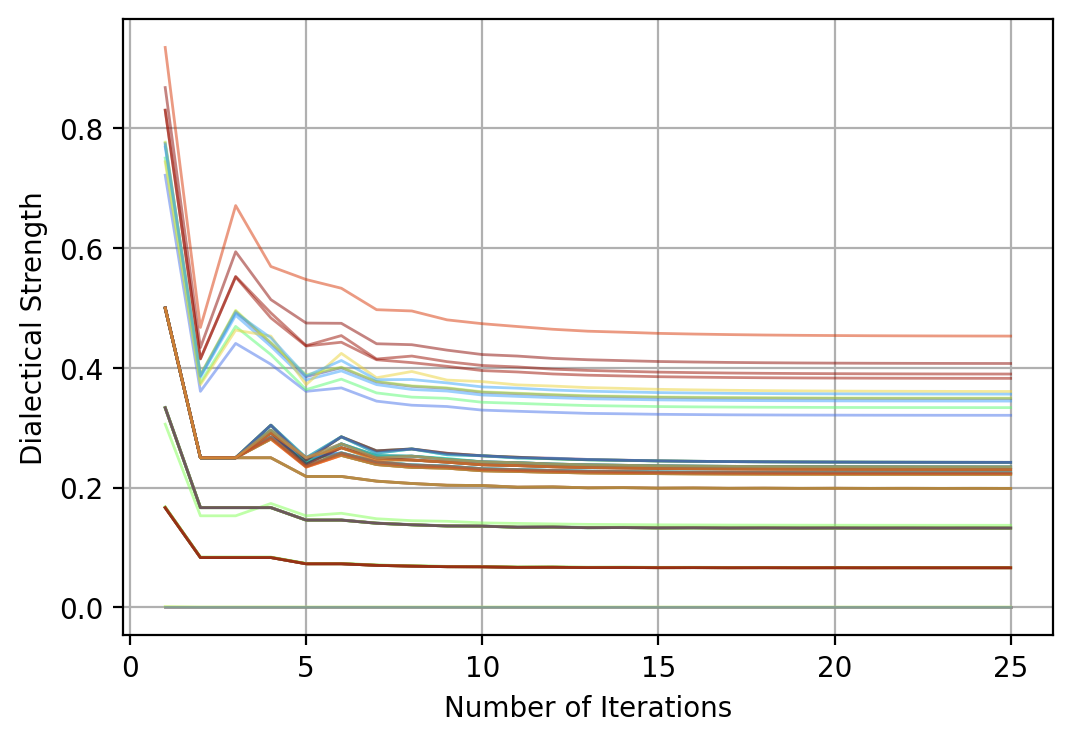

In [14]:
wide, tall, dpi = 6, 4, 200
fig, ax = plt.subplots(1, 1, figsize=(wide, tall), dpi=dpi)

plot_strengths_given_asms(ax, 
                          {name: val for name, val in output.graph_data.items()
                           if name.startswith("indep")}, 
                          "")